In [45]:
import numpy as np
import scipy
import scipy.io as scio
from sklearn.decomposition import PCA
import pickle
from math_plds import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [8]:
nld = 4
nts = 6187
nn = 300
nsd = 4
data = scio.loadmat('../data/compiled_dF033016.mat')
frameHz = data['FrameRateHz'][0, 0]  # frames per seconds
y = data['behavdF'].T
onsetframe = data['onsetFrame'].T[0]
onsettime = np.array(data['onsetFrame'].T[0]) / frameHz

resptime = data['resptime'].T[0]
correct = data['correct'][0]

offsettime = onsettime + resptime + 2.75 + (4.85 - 2.75) * (1 - correct)
offsetframe = (offsettime * frameHz).astype(np.int32)

orientation = np.array(data['orient'][0], np.int8)
location = np.array((data['location'][0] + 1) // 2, np.int8)

u = np.zeros((y.shape[0], nsd))
for onf, off, ori, loc in zip(onsetframe, offsetframe, orientation, location):
    for frame in np.arange(onf, off, dtype=np.int32):
        u[frame] = np.array([ori*loc, (1-ori)*loc, ori*(1-loc), (1-ori)*(1-loc)])

stimuli = 1 * (1 - orientation) * location + 2 * orientation * (1 - location) + 3 * (1 - orientation) * (1 - location)

onsettoonset = onsetframe[1:] - onsetframe[:-1]

stimulicross = stimuli[np.where(offsetframe > y.shape[0] - nts)[0][0]:]
crossoffsetframe = offsetframe[-len(stimulicross):]-20000
crossonsetframe = (onsetframe[-len(stimulicross):]-20000).astype(np.int32)
ycross = y.flatten()[-nts*nn:]
ucross = u.flatten()[-nts*nsd:]

uvec = u[-nts:]


In [28]:
mu0 = np.random.randn(ycross.shape[0]//nn * nld)
mu, covd, covod = laplace_approximation(logposterior(ycross, C, d, A, B, Q, Q0, m0, ucross, nts, nn, nsd, nld),
                                                logposteriorderivative(ycross, C, d, A, B, Q, Q0, m0, ucross, nts, nn, nsd, nld),
                                                logposteriorhessian(C, d, A, Q, Q0, nts, nn, nld),
                                                mu0, nts, nld)
muvec = mu.reshape(-1, nld)

computing covariance


In [11]:
np.min(onsettoonset)

39.999999999999091

In [42]:
stimgroups = {str(i):[] for i in range(nsd)}
for stim, off, on in zip(stimulicross, crossoffsetframe, crossonsetframe):
    stimgroups[str(stim)].append(muvec[on - 10: on + 20])
stimgroups = {str(i):np.array(stimgroups[str(i)]) for i in range(nsd)}


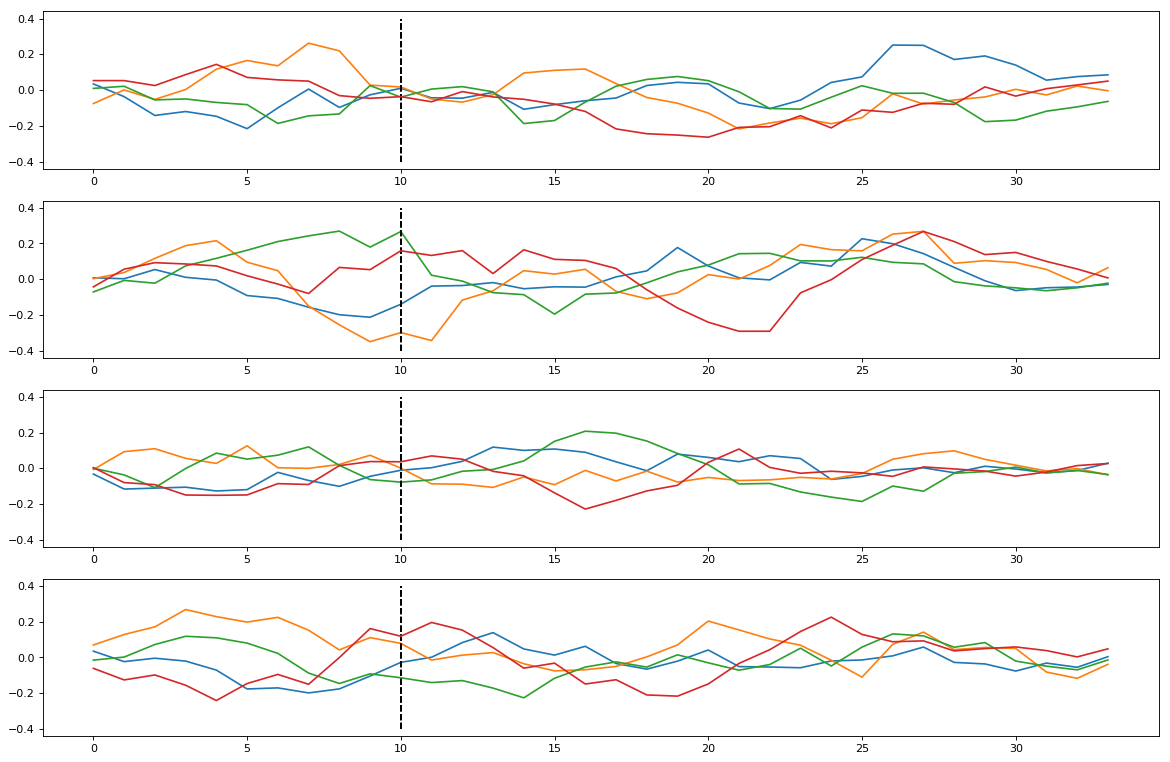

In [43]:
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
for j in range(nsd):
    plt.subplot(nsd, 1, j+1)
    for i in range(nld):
        smth = np.convolve(np.mean(stimgroups[str(j)], axis=0).T[i],  .2*np.ones(5))
        plt.plot([10, 10], [-.4,.4], 'k--')
        plt.plot(smth)
plt.show()

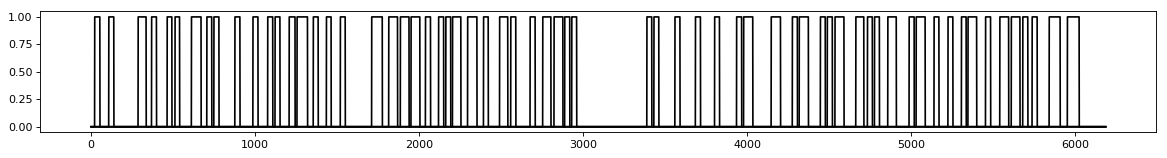

In [8]:
plt.figure(figsize=(18, 2), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(uvec, 'k')
plt.show()

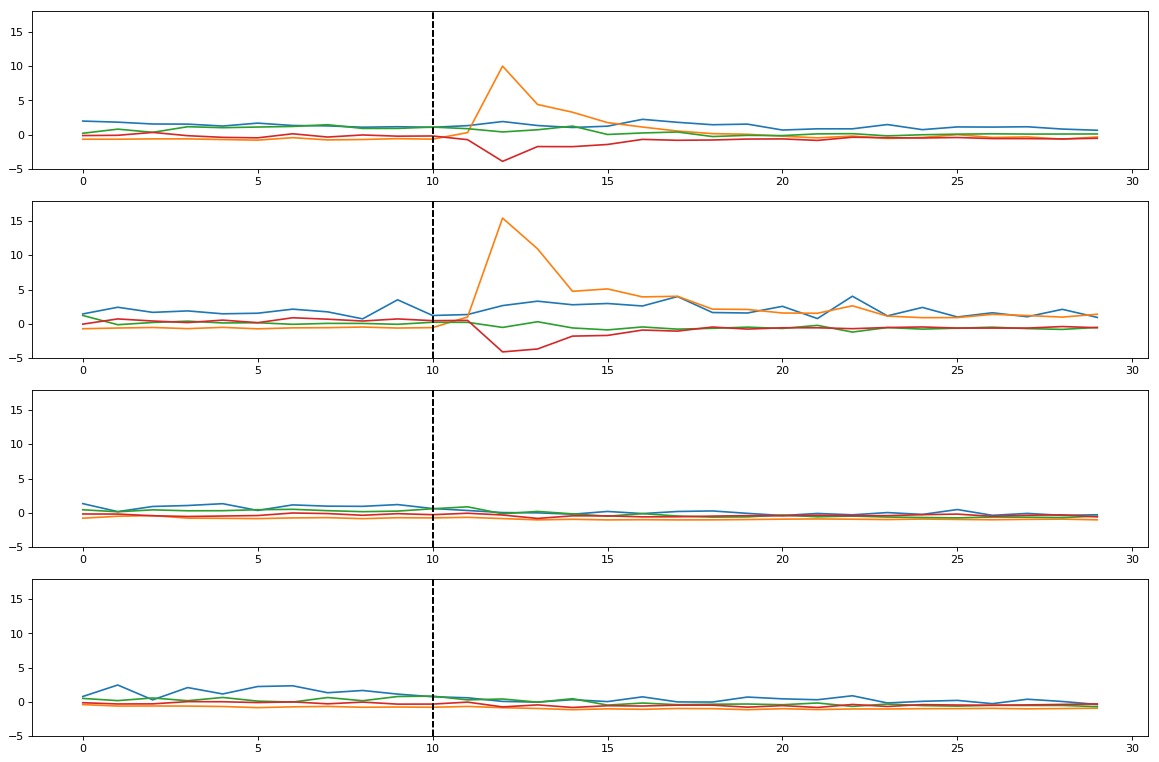

In [50]:
pca = PCA(n_components=nld)
pca.fit(y)
reducedy = pca.transform(y[-nts:])

pcastimgroups = {str(i):[] for i in range(nsd)}
for stim, off, on in zip(stimulicross, crossoffsetframe, crossonsetframe):
    pcastimgroups[str(stim)].append(reducedy[on - 10: on + 20])

plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
for j in range(nsd):
    plt.subplot(nsd, 1, j+1)
    for i in range(nld):
        smth = np.mean(pcastimgroups[str(j)], axis=0).T[i]
        plt.plot(smth)
        plt.ylim(-5, 18)
        plt.plot([10, 10], [plt.ylim()[0], plt.ylim()[1]], 'k--')
plt.show()

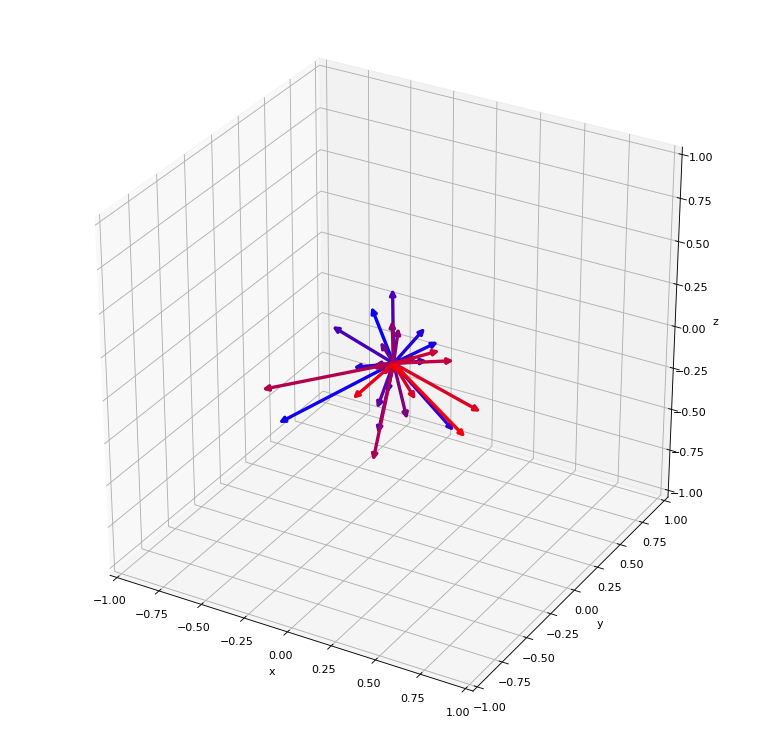

In [41]:
# vectors = np.array([[0,0,0,1,-2,0]])
def rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return r/255., g/255., b/255.

vectors = [np.mean(stimgroups['0'][:,t], axis=0) for t in range(0,30)]
fig = plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
for i, v in enumerate(vectors):
    vlength=np.linalg.norm(v)
    a = Arrow3D([0, v[0]], [0, v[1]], 
                [0, v[2]], mutation_scale=10, 
                lw=3, arrowstyle="-|>", color=(i/30., 0, (30 - i)/30. ))
    ax.add_artist(a)
#     ax.quiver(0,0,0,vector[0],vector[1],vector[2], pivot='tail',length=vlength, arrow_length_ratio=2./vlength)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [11]:
np.mean(stimgroups['0'][:,0], axis=0)

array([-0.00526635,  0.07071527, -0.15844656,  0.08839628])

In [86]:
ynormalized = y/np.max(y, axis=0)

In [35]:
# normalizedstimgroups = {str(i):[] for i in range(nsd)}
# for stim, on in zip(stimuli, onsetframe):
#     normalizedstimgroups[str(stim)].append(ynormalized[int(on - 10): int(on + 10)])
# normalizedstimgroups = {str(i):np.array(normalizedstimgroups[str(i)]) for i in range(nsd)}

preonset = 10
postonset = 40
normalizedstimgroups = {str(i):[] for i in range(nsd)}
for stim, on in zip(stimuli, onsetframe):
    normalizedstimgroups[str(stim)].append(y[int(on - preonset): int(on + postonset)])
normalizedstimgroups = {str(i):np.array(normalizedstimgroups[str(i)]) for i in range(nsd)}




In [38]:
psthmeans = np.array([np.mean(normalizedstimgroups[str(j)], axis=0) for j in range(4)])
psthmaxes = np.array([np.max(np.mean(normalizedstimgroups[str(j)], axis=0), axis=0) for j in range(4)])
psthvectors = np.zeros(shape=(300, 4 * (preonset + postonset)))
psthorders = np.argsort(-psthmaxes, axis=0).T
for i in range(300):
    j=0
    for o in psthorders[i]:
        psthvectors[i, (preonset + postonset)*j:(preonset + postonset)*(j+1)] += psthmeans[o].T[i]
        j += 1

for i in range(len(psthvectors)):
    psthvectors[i] /= np.max(psthvectors[i]) 
    
np.save('psthmaxes.npy', np.max(psthmaxes, axis=0))

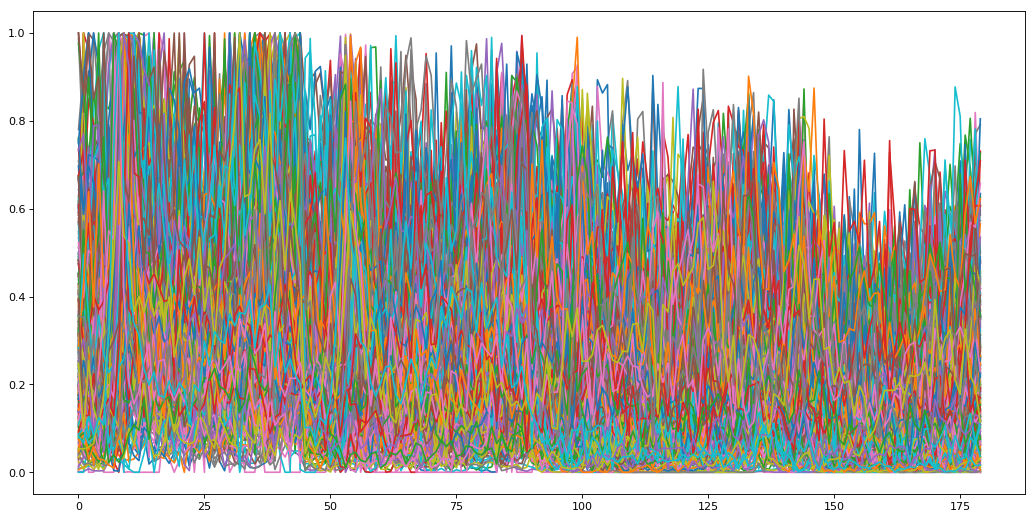

In [21]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for _ in range(300):
    plt.plot(psthvectors[_])
plt.show()

In [40]:
# order according to independent stimuli conditions. 
# Note that stimuli = 0: loc=1 ori=1
#           stimuli = 1: loc=1 ori=0
#           stimuli = 2: loc=0 ori=1
#           stimuli = 3: loc=0 ori=0

psthlocmaxes = np.array([np.max(psthmaxes[[0, 1]], axis=0), np.max(psthmaxes[[2, 3]], axis=0)])
psthorimaxes = np.array([np.max(psthmaxes[[0, 2]], axis=0), np.max(psthmaxes[[1, 3]], axis=0)])
psthlocorders = np.argsort(-psthlocmaxes, axis=0).T
psthoriorders = np.argsort(-psthorimaxes, axis=0).T
stimulilookuptable = np.array([[0, 1], [2, 3]])
normalizedpsthstimsortvectors = np.zeros(shape=(300, 4*(preonset + postonset)))
psthstimsortvectors = np.zeros(shape=(300, 4*(preonset + postonset)))

for i in range(300):
    psthstimsortvectors[i] += np.concatenate([
                                      psthmeans[stimulilookuptable[psthlocorders[i, 0], psthoriorders[i, 0]]].T[i],
                                      psthmeans[stimulilookuptable[psthlocorders[i, 0], psthoriorders[i, 1]]].T[i],                           
                                      psthmeans[stimulilookuptable[psthlocorders[i, 1], psthoriorders[i, 0]]].T[i],                            
                                      psthmeans[stimulilookuptable[psthlocorders[i, 1], psthoriorders[i, 1]]].T[i]                          
                                      ])
    normalizedpsthstimsortvectors[i] = psthstimsortvectors[i]/np.max(psthstimsortvectors[i])
    

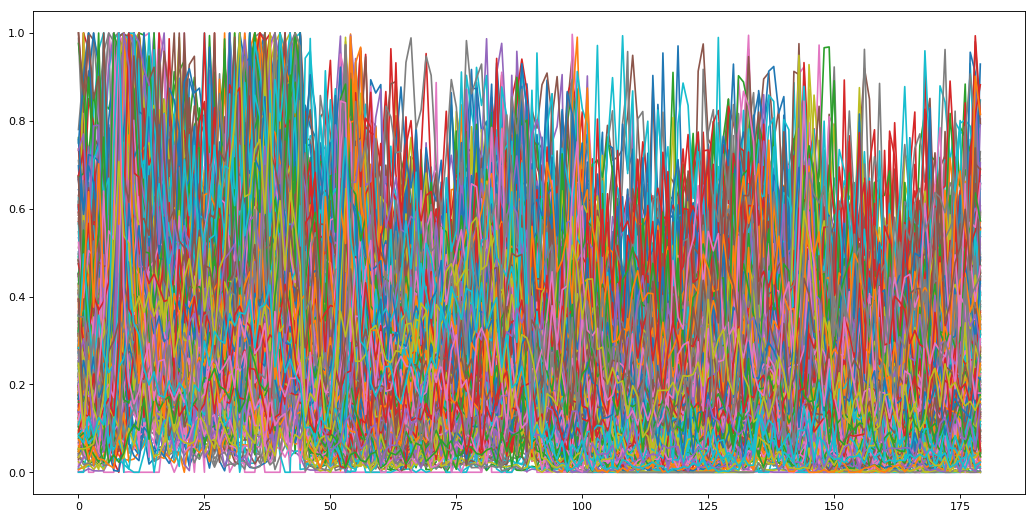

In [24]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for _ in range(300):
    plt.plot(psthstimsortvectors[_])
plt.show()

/home/bkorkor/miniconda3/envs/plds/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


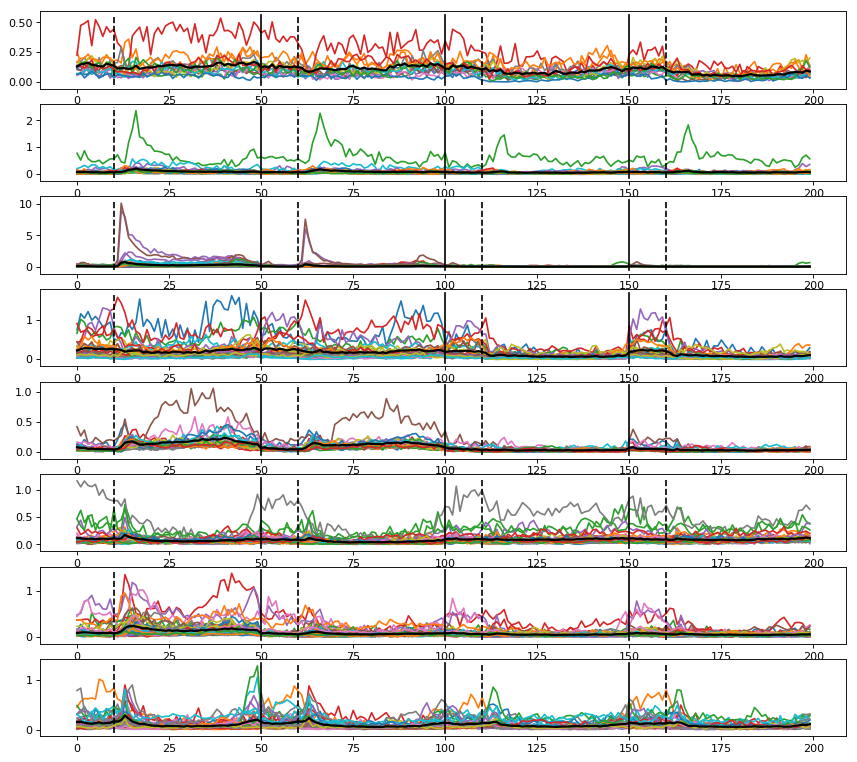

In [44]:
nclusters = 8
sortedstimkmeans = KMeans(n_clusters=nclusters).fit(normalizedpsthstimsortvectors)
stimsortedkmeanpredictions = sortedstimkmeans.predict(normalizedpsthstimsortvectors)

plt.figure(figsize=(13, 12), dpi= 80, facecolor='w', edgecolor='k')
clustermeans = [[] for i in range(nclusters)]
for i in range(300):
    clustermeans[stimsortedkmeanpredictions[i]].append(psthstimsortvectors[i])
    plt.subplot(nclusters, 1, stimsortedkmeanpredictions[i]+1)
    plt.plot(psthstimsortvectors[i])

for i in range(nclusters):
    plt.subplot(nclusters, 1, i+1)
    plt.plot(np.mean(clustermeans[i], axis=0), 'k', linewidth=2)
    lims = plt.ylim()
    for j in range(1, nsd):
        plt.plot([j*(preonset + postonset), j*(preonset + postonset)], lims, 'k-')
    for j in range(nsd):
        plt.plot([preonset + j* (preonset + postonset), preonset + j*(preonset + postonset)], lims, 'k--')

In [ ]:
# Hierarchical Clustering
